### Nucleus Sampling

In [2]:
from transformers import GPT2Tokenizer

# Load GPT-2 tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Input text
text = "Once upon a time"

# Tokenize the text and get token IDs
token_ids = tokenizer.encode(text, add_special_tokens=False)

# Display token IDs
print(f"Token IDs for '{text}': {token_ids}")


Token IDs for 'Once upon a time': [7454, 2402, 257, 640]


In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

#We used the gpt-2 model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

def nucleus_sampling(model, tokenizer, prompt, max_length, p=0.9):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    #Generating Tokens Iteratively
    for _ in range(max_length):
        outputs = model(input_ids)
        logits = outputs.logits[:, -1, :] # shape of outputs.logits (batch_size, seq_len, vocab_size)
        
        probs = torch.softmax(logits, dim=-1)#Computes probabilities
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        
        sorted_indices_to_remove = cumulative_probs > p #keep the probs< p,thats nucleus sampling
        sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
        sorted_indices_to_remove[:, 0] = False #Ensure that the first word is never removed
        
        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        probs[:, indices_to_remove] = 0 #Remove the indices that not important
        
        #Re Normalise 
        probs = probs / torch.sum(probs, dim=-1, keepdim=True)
        
        #Take our next token randomnly
        next_token = torch.multinomial(probs, num_samples=1)
        
        input_ids = torch.cat((input_ids, next_token), dim=1)
    
        if next_token.item() == tokenizer.eos_token_id:  #If token EOS (== end) stop
            break
    
    #Detokenize the words
    output_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    return output_text

prompt = "I am a"  # SUCH as " Once upon a time"
generated_text = nucleus_sampling(model, tokenizer, prompt, max_length=30, p=0.95)
print(generated_text)

I am a science teacher. I have no family other than my six kids who enjoy my teaching. As professional educators, I make sure everyone I reach out to feels


### Top K Generated

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

def top_k_sampling(model, tokenizer, prompt, max_length, k=10):

    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    for _ in range(max_length):
        outputs = model(input_ids)
        logits = outputs.logits[:, -1, :]
        

        probs = torch.softmax(logits, dim=-1)
        # Sort probabilities in descending order
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        #print(sorted_probs)
        
        # Keep only the top-k indices
        k = 10  # Set the value of k
        sorted_indices_to_remove = torch.zeros_like(probs, dtype=torch.bool)
        
        # Mark indices to remove (everything after the top k)
        sorted_indices_to_remove[:, k:] = True
        
        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        probs[:, indices_to_remove] = 0
        probs = probs / torch.sum(probs, dim=-1, keepdim=True)

        next_token = torch.multinomial(probs, num_samples=1)
        input_ids = torch.cat((input_ids, next_token), dim=1)
        
        if next_token.item() == tokenizer.eos_token_id:
            break
    output_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    return output_text

prompt = "I am a"  # SUCH as " Once upon a time"
print("Top K Generated Text:")
generated_text = top_k_sampling(model, tokenizer, prompt, max_length=30)
print(generated_text)


Top K Generated Text:
I am a young, beautiful, well educated woman who has always loved the outdoors and has never had a passion for anything. I am very happy to help others out


### Beam Search Implementation

In [26]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

def beam_search(model, tokenizer, prompt, max_length, beam_width=3):

 
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_ids = input_ids.to(device)
    beams = [(input_ids, 0)]  # (sequence, cumulative log-probability)

    for _ in range(max_length):
        new_beams = []
        for seq, score in beams:
        
            outputs = model(seq)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)
            top_k_probs, top_k_indices = torch.topk(probs, beam_width, dim=-1)
    
            for prob, idx in zip(top_k_probs[0], top_k_indices[0]):
                new_seq = torch.cat([seq, idx.unsqueeze(0).unsqueeze(0)], dim=1)
                new_score = score + torch.log(prob).item()
                new_beams.append((new_seq, new_score))
        
        # Sort all new beams by score and keep the top-k
        new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
        beams = new_beams

        # Stop if all beams end with the EOS token
        if all(beam[0][0, -1].item() == tokenizer.eos_token_id for beam in beams):
            break

    # Return the sequence with the highest score
    best_sequence = beams[0][0]
    output_text = tokenizer.decode(best_sequence[0], skip_special_tokens=True)
    return output_text


prompt = "I am a"
beam_generated_text = beam_search(model, tokenizer, prompt, max_length=30, beam_width=3)
print("Beam Search Generated Text:")
print(beam_generated_text)



Beam Search Generated Text:
I am a member of the United States House of Representatives. I am a member of the United States Senate. I am a member of the United States House of Representatives


Beam Search exhibits **repetition**

This repetition occurs because Beam Search prioritizes high-probability sequences. Neural language models like GPT-2 often assign high probabilities to repetitive patterns, as they tend to align with the training data distribution, especially in a narrow beam width scenario.

## Comparison
- several Evaluation Criterias can use according to the article
- Perplexity
- Self-BLEU
- Zipf distribution coefficient
- Repetition Rate
- Human Unified with Statistical Evaluation

#### Perplexity

In [27]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()


def calculate_perplexity(model, tokenizer, text):

    # Tokenize input text
    input_ids = tokenizer.encode(text, return_tensors="pt")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_ids = input_ids.to(device)

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss  # Cross-entropy loss

    perplexity = torch.exp(loss).item()
    return perplexity

def nucleus_sampling(model, tokenizer, prompt, max_length, top_p=0.9):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    for _ in range(max_length):
        outputs = model(input_ids)
        logits = outputs.logits[:, -1, :]
        probs = torch.softmax(logits, dim=-1).clone()  # Clone the tensor to avoid memory conflicts
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

       
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
        sorted_indices_to_remove[:, 0] = False

        # Remove the indices that have probabilities not high enough
        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        probs[:, indices_to_remove] = 0

        probs = probs / torch.sum(probs, dim=-1, keepdim=True)
        next_token = torch.multinomial(probs, num_samples=1)
        input_ids = torch.cat((input_ids, next_token), dim=1)
        if next_token.item() == tokenizer.eos_token_id:
            break
    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

def beam_search(model, tokenizer, prompt, max_length, beam_width=3):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    beams = [(input_ids, 0)]  # (sequence, cumulative log-probability)
    for _ in range(max_length):
        new_beams = []
        for seq, score in beams:
            outputs = model(seq)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)
            top_k_probs, top_k_indices = torch.topk(probs, beam_width, dim=-1)
            for prob, idx in zip(top_k_probs[0], top_k_indices[0]):
                new_seq = torch.cat([seq, idx.unsqueeze(0).unsqueeze(0)], dim=1)
                new_score = score + torch.log(prob).item()
                new_beams.append((new_seq, new_score))
        new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
        beams = new_beams
        if all(beam[0][0, -1].item() == tokenizer.eos_token_id for beam in beams):
            break
    best_sequence = beams[0][0]
    return tokenizer.decode(best_sequence[0], skip_special_tokens=True)

# Comparison setup
prompt = "Once upon a time"
max_length = 30

# Generate text using Nucleus Sampling
nucleus_text = nucleus_sampling(model, tokenizer, prompt, max_length, top_p=0.9)
nucleus_perplexity = calculate_perplexity(model, tokenizer, nucleus_text)

top_k_text = top_k_sampling(model, tokenizer, prompt, max_length, k=10)
top_k_perplexity = calculate_perplexity(model, tokenizer, top_k_text)

# Generate text using Beam Search
beam_text = beam_search(model, tokenizer, prompt, max_length, beam_width=3)
beam_perplexity = calculate_perplexity(model, tokenizer, beam_text)

human_text = "ONCE UPON A TIME, a Princess named Snow White lived in a castle with her father the King and her Stepmother the Queen. Her father always reminded his daughter that above all else, a royal family must be fair. "
human_perplexity = calculate_perplexity(model, tokenizer, human_text)
print("Human text (from Snow White):")
print(human_text)
print(f"Perplexity: {human_perplexity}")

print("\nNucleus Sampling:")
print(nucleus_text)
print(f"Perplexity: {nucleus_perplexity}")

print("\nBeam Search:")
print(beam_text)
print(f"Perplexity: {beam_perplexity}")

print("\nTop K:")
print(top_k_text)
print(f"Perplexity: {top_k_perplexity}")


Human text (from Snow White):
ONCE UPON A TIME, a Princess named Snow White lived in a castle with her father the King and her Stepmother the Queen. Her father always reminded his daughter that above all else, a royal family must be fair. 
Perplexity: 50.17633819580078

Nucleus Sampling:
Once upon a time, Mari's injury seemed to overwhelm her with wild swings of her body and ears. Although she normally loved to swing her back against the wall, her
Perplexity: 35.201656341552734

Beam Search:
Once upon a time, it was said that the Lord had said to Moses, "I will give you the keys of the kingdom of heaven, and I will give you
Perplexity: 4.922097206115723

Top K:
Once upon a time of such great danger, the whole of the world was at war. And there were those who had been in the habit of going to war, and
Perplexity: 12.19388484954834


#### Zipf Distribution Comparison

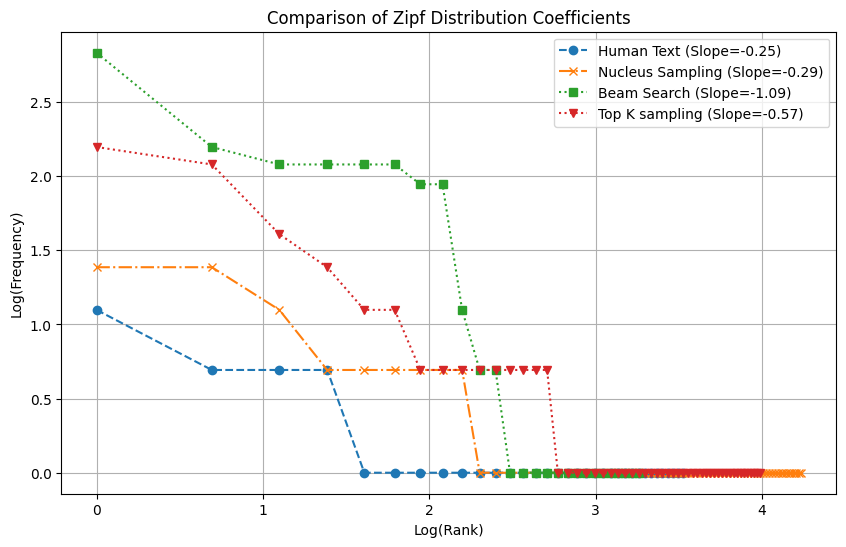

Zipf Coefficients:
Human Text: -0.25
Nucleus Sampling: -0.29
Beam Search: -1.09
Top K Sampling: -0.57


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

def calculate_zipf_coefficient(text):
    # Tokenize the text into words
    words = text.split()
    
    # Count word frequencies
    word_counts = Counter(words)
    
    # Sort by frequency and assign ranks
    frequencies = np.array(sorted(word_counts.values(), reverse=True))
    ranks = np.arange(1, len(frequencies) + 1)
    
    # Compute log(rank) and log(frequency)
    log_ranks = np.log(ranks)
    log_frequencies = np.log(frequencies)
    
    # Perform linear regression to find the slope
    slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_frequencies)
    return slope, log_ranks, log_frequencies

def compare_to_human_text(nucleus_text, beam_text, human_text, top_k_text):
    # Calculate Zipf coefficients
    nucleus_slope, nucleus_log_ranks, nucleus_log_freqs = calculate_zipf_coefficient(nucleus_text)
    beam_slope, beam_log_ranks, beam_log_freqs = calculate_zipf_coefficient(beam_text)
    human_slope, human_log_ranks, human_log_freqs = calculate_zipf_coefficient(human_text)
    k_slope, k_ranks, k_freqs = calculate_zipf_coefficient(top_k_text)
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(human_log_ranks, human_log_freqs, label=f"Human Text (Slope={human_slope:.2f})", marker='o', linestyle='--')# Human Text
    plt.plot(nucleus_log_ranks, nucleus_log_freqs, label=f"Nucleus Sampling (Slope={nucleus_slope:.2f})", marker='x', linestyle='-.') # Nucleus Sampling
    
    plt.plot(beam_log_ranks, beam_log_freqs, label=f"Beam Search (Slope={beam_slope:.2f})", marker='s', linestyle=':')# Beam Search
    plt.plot(k_ranks, k_freqs, label=f"Top K sampling (Slope={k_slope:.2f})", marker='v', linestyle='dotted')

    plt.xlabel("Log(Rank)")
    plt.ylabel("Log(Frequency)")
    plt.title("Comparison of Zipf Distribution Coefficients")
    plt.legend()
    plt.grid(True)
    plt.show()

    return nucleus_slope, beam_slope, human_slope, k_slope

human_text = """
ONCE UPON A TIME, a Princess named Snow White lived in a castle with her father the King and her Stepmother the Queen. Her father always reminded his daughter that above all else, a royal family must be fair. 
"""

#Cinderella Story
# Once upon a time, there lived a king whose daughters were all beautiful. But the youngest was so beautiful that even the sun was surprised, when it shone in her face.  Close by the king's castle there was a great dark forest, and under an old tree in the forest there was a well.

# The Frog Prince
# ONCE UPON A TIME a girl named Cinderella lived with her stepmother and two stepsisters. Poor Cinderella had to work hard all day long so the others could rest. It was she who had to wake up each morning when it was still dark and cold to start the fire.

# Snow White and the Seven Dwarfs
# ONCE UPON A TIME, a Princess named Snow White lived in a castle with her father the King and her Stepmother the Queen. Her father always reminded his daughter that above all else, a royal family must be fair. 


prompt = "Once upon a time"
max_length = 100

# Use your implemented Nucleus Sampling and Beam Search functions
nucleus_text = nucleus_sampling(model, tokenizer, prompt, max_length, top_p=0.9)
beam_text = beam_search(model, tokenizer, prompt, max_length, beam_width=3)
top_k_text = top_k_sampling(model, tokenizer, prompt, max_length, k=10)

# Compare to human text
nucleus_slope, beam_slope, human_slope, top_k_slope = compare_to_human_text(nucleus_text, beam_text, human_text, top_k_text)

print("Zipf Coefficients:")
print(f"Human Text: {human_slope:.2f}")
print(f"Nucleus Sampling: {nucleus_slope:.2f}")
print(f"Beam Search: {beam_slope:.2f}")
print(f"Top K Sampling: {top_k_slope:.2f}")


- cause many fairy tales is beginning in sentence" ONCE UPON A TIME", so i choose the sentence from **$'Cinderella Story', 'Snow White and the Seven Dwarfs', 'The Frog Prince'$** to be the human_text 
- all of them shows that Nucleus Sampling are by far the closest to the human distribution, while Beam Search clearly follows a very different distribution than natural language.